In [1]:
import matplotlib.pyplot as plt
import neqsim.thermo
import numpy as np
import pandas as pd


from datetime import datetime
from neqsim.thermo import TPflash
from neqsim.thermo.thermoTools import dataFrame, jNeqSim
from smt.sampling_methods import LHS
from typing import Dict

## Referências (NeqSim)

- https://github.com/equinor/neqsim-python
- https://github.com/equinor/neqsim-python/tree/master/examples
- https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=kHt6u-utpvYf

In [2]:
COMPONENTS = {
    "zN2": "nitrogen",
    "zCO2": "CO2",
    "zC1": "methane",
    "zC2": "ethane",
    "zC3": "propane",
    "zIC4": "i-butane",
    "zNC4": "n-butane",
    "zIC5": "i-pentane",
    "zNC5": "n-pentane",
    "zC6": "n-hexane",
    "zC7": "n-heptane",
    "zC8": "n-octane",
    "zC9": "n-nonane",
    "zC10": "nC10",
    "zC11": "nC11",
    "zC12": "nC12",
    "zC13": "nC13",
    "zC14": "nC14",
    "zC15": "nC15",
    "zC16": "nC16",
    "zC17": "nC17",
    "zC18": "nC18",
    "zC19": "nC19",
    "zC20": "nC20",
}

processed_data = pd.read_csv("experimental_data\\processed_data.csv")
composition_data = processed_data.loc[:, processed_data.columns.str.contains("z")]

def set_components(composition: Dict[str, float]):
    fluid = neqsim.thermo.fluid("pr")
    for component, fraction in composition.items():
        fluid.addComponent(COMPONENTS[component], fraction)
    fluid.setMixingRule("classic")  # classic will use binary kij
    return fluid

processed_data.head()

,Field,Id,Date,FluidKind,LastFluidMolecularWeight,LastFluidSpecificGravity,zN2,zCO2,zC1,zC2,...,zC12,zC13,zC14,zC15,zC16,zC17,zC18,zC19,zC20,LastFluidComponent
0,Albacora,200588838534569195818022639230611277018,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
1,Albacora,235655066780487493060135334531738441741,28/11/2013,OLEO,513.0,0.9375,0.28,2.18,50.34,8.80,...,1.39,1.42,1.19,1.12,0.84,0.75,0.74,0.71,7.54,C20
2,Albacora,2850024621782551530469011068396203900,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
3,Albacora,66820533634321543631617927163864636933,11/12/2014,OLEO,447.0,0.9332,0.36,3.23,45.32,7.16,...,1.35,1.40,1.13,1.07,0.83,0.68,0.74,0.67,10.99,C20
4,Albacora,321567418088616429351396831258924766066,01/08/2007,OLEO,428.0,0.9508,0.01,0.17,42.67,5.08,...,1.44,1.48,1.30,1.30,1.00,0.86,0.84,0.75,24.57,C20


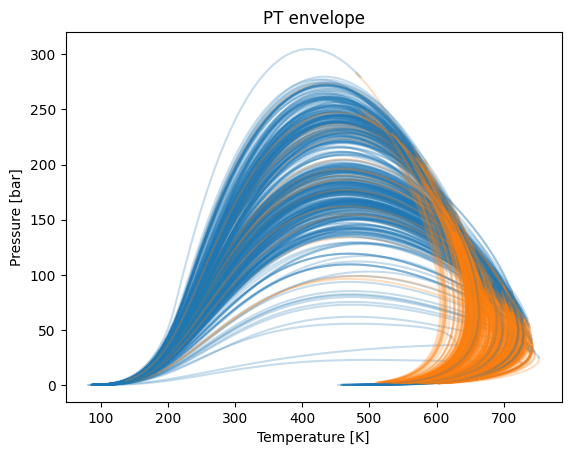

In [3]:
for i in np.arange(processed_data.shape[0]):
    fluid1 = set_components(composition_data.loc[i, :].to_dict())
    thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
    thermoOps.calcPTphaseEnvelope(True, 0.1)

    if 0.0 in list(thermoOps.getOperation().get("dewT")):
        # print(processed_data.loc[i, :].to_dict())
        thermoOps.calcPTphaseEnvelope(False, 0.1)
        if 0.0 in list(thermoOps.getOperation().get("dewT")):
            composition_data = composition_data.drop(i)
            processed_data = processed_data.drop(i)
            continue

    plt.plot(
        list(thermoOps.getOperation().get("dewT")),
        list(thermoOps.getOperation().get("dewP")),
        label="dew point",
        alpha=0.25,
        color="C0",
    )
    plt.plot(
        list(thermoOps.getOperation().get("bubT")),
        list(thermoOps.getOperation().get("bubP")),
        label="bubble point",
        alpha=0.25,
        color="C1",
    )
plt.title("PT envelope")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.show()

composition_data = composition_data.reset_index(drop=True)
processed_data = processed_data.reset_index(drop=True)

processed_data.to_csv(
    ".\\experimental_data\\thermodinamically_processed_data.csv",
    index=False,
)

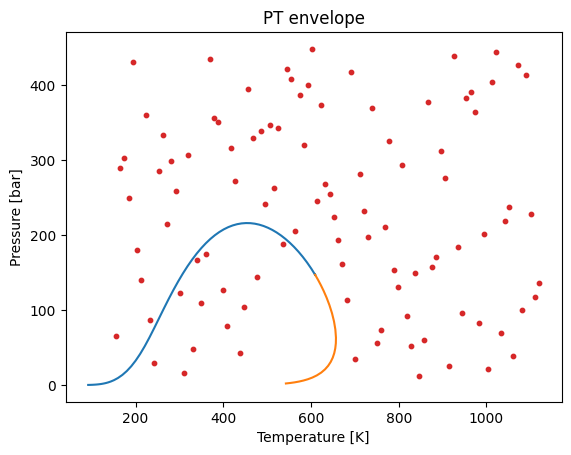

In [4]:
# P_sample (min, max): (10, 450)
# T_sample (min, max): (150, 1125)
xlimits = np.array([[150., 1125.0], [10.0, 450.0]])
sampling = LHS(xlimits=xlimits)

num = 100
TP = sampling(num)

fluid1 = set_components(composition_data.loc[0, :].to_dict())
thermoOps = jNeqSim.thermodynamicOperations.ThermodynamicOperations(fluid1)
thermoOps.calcPTphaseEnvelope(True, 0.1)

plt.plot(
    list(thermoOps.getOperation().get("dewT")),
    list(thermoOps.getOperation().get("dewP")),
    label="dew point",
    color="C0",
)
plt.plot(
    list(thermoOps.getOperation().get("bubT")),
    list(thermoOps.getOperation().get("bubP")),
    label="bubble point",
    color="C1",
)
plt.scatter(TP[:, 0], TP[:, 1], s=10, c="C3")
plt.title("PT envelope")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")
plt.show()

In [5]:
data = []
fluids = []

composition = composition_data.loc[0, :].to_dict()
print(composition_data.loc[0, :].to_list())

mix_fluids = []
for sample_i in np.arange(TP.shape[0]):
    outputs = {}
    fluid = set_components(composition)

    T, P = TP[sample_i, 0], TP[sample_i, 1]
    fluid.setTemperature(T)
    fluid.setPressure(P)

    # start = datetime.now()
    TPflash(fluid)
    # print(f"elapsed time: {datetime.now() - start}")

    outputs["NumberOfPhases"] = fluid.getNumberOfPhases()
    components = [c for c in fluid.getComponentNames()]
    phases = [p for p in fluid.getPhases() if p]
    outputs["Phases"] = ",".join([str(phase.getPhaseTypeName()) for phase in phases])
    outputs["P [bara]"] = fluid.getPressure()
    outputs["T [degC]"] = fluid.getTemperature()

    if fluid.getNumberOfPhases() == 2:
        for phase in phases:
            for component in components:
                phase_name = phase.getPhaseTypeName()
                phase_var = ""
                # outputs[f"{phase_name}_{component}"] = phase.getComponent(component).getx()
    data.append(outputs)
    fluids.append(fluid)

flash = pd.DataFrame.from_records(data)
flash.head()     

[0.28, 2.18, 50.34, 8.8, 5.71, 0.96, 2.47, 0.75, 1.25, 1.56, 2.03, 2.46, 2.14, 1.81, 1.56, 1.39, 1.42, 1.19, 1.12, 0.84, 0.75, 0.74, 0.71, 7.54]


,NumberOfPhases,Phases,P [bara],T [degC]
0,1,"oil,liquid",87.0,232.875
1,1,"oil,liquid",285.0,252.375
2,1,"oil,liquid",408.2,554.625
3,1,"gas,liquid",311.4,895.875
4,1,"gas,liquid",368.6,739.875


In [6]:
from IPython.display import display

print({phases: count for phases, count in zip(*np.unique(flash["Phases"], return_counts=True))})
for phases in flash["Phases"].unique():
    display(flash[flash["Phases"] == phases].iloc[:1, :])

{'gas,liquid': 56, 'gas,oil': 12, 'oil,liquid': 32}


,NumberOfPhases,Phases,P [bara],T [degC]
0,1,"oil,liquid",87.0,232.875


,NumberOfPhases,Phases,P [bara],T [degC]
3,1,"gas,liquid",311.4,895.875


,NumberOfPhases,Phases,P [bara],T [degC]
6,2,"gas,oil",166.2,340.125


In [26]:
index = 28

results = dataFrame(fluids[index])
print(f"P = {fluids[index].getPressure()} bara", end=", ")
print(f"T = {fluids[index].getTemperature()} degC")

results = results.replace("", np.nan).dropna(how="all").iloc[1:-1, [0, 1, 2, 3, 6]]
results.columns = ["Property", "Total", "Oil", "Gas", "Unit"]
results = results.set_index("Property")
# results = results.set_index(0)
# results.index.name = ""
# results.columns = results.iloc[0, :].dropna(how="all")
results

P = 355.40000000000003 bara, T = 379.125 degC


C:\Users\E5P8\AppData\Local\Temp\ipykernel_21288\4076322746.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results = results.replace("", np.nan).dropna(how="all").iloc[1:-1, [0, 1, 2, 3, 6]]


,Total,Oil,Gas,Unit
Property,,,,
nitrogen,2.8E-3,2.8E-3,NaN,[mole fraction]
CO2,2.18E-2,2.18E-2,NaN,[mole fraction]
methane,5.034E-1,5.034E-1,NaN,[mole fraction]
ethane,8.8E-2,8.8E-2,NaN,[mole fraction]
propane,5.71E-2,5.71E-2,NaN,[mole fraction]
i-butane,9.6E-3,9.6E-3,NaN,[mole fraction]
n-butane,2.47E-2,2.47E-2,NaN,[mole fraction]
i-pentane,7.5E-3,7.5E-3,NaN,[mole fraction]
n-pentane,1.25E-2,1.25E-2,NaN,[mole fraction]
